In [33]:
# THE CARTAN PACKAGE SHOULD BE INSTALLED FROM THE GITHUB REPO https://github.com/ooalshei/Cartan
from cartan.decompositions.cartan import Hamiltonian
from cartan.decompositions import IterativeCartan
from cartan.pauli_operations import print_letters, exp_conjugation
from cartan.optimizers import iterative_optimizer
from cartan.circuits.utils import *
from cartan.time_evolution import _singles_product
from cartan.time_evolution import *
import numpy as np
from qiskit import *
from qiskit import qasm2, qasm3
from qiskit.circuit import ClassicalRegister, QuantumRegister, ParameterVector, QuantumCircuit
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

In [10]:
H = {(3, 0, 0, 0): 0.1265398827194811,
  (0, 3, 0, 0): 0.1265398827194811,
  (3, 3, 0, 0): 0.15229282586791326,
  (0, 0, 3, 0): -0.10485523662134644,
  (3, 0, 3, 0): 0.10102818539512973,
  (0, 3, 3, 0): 0.15183377864947628,
  (2, 1, 1, 2): 0.050805593254346575,
  (2, 2, 1, 1): -0.050805593254346575,
  (1, 1, 2, 2): -0.050805593254346575,
  (1, 2, 2, 1): 0.050805593254346575,
  (0, 0, 0, 3): -0.10485523662134649,
  (3, 0, 0, 3): 0.15183377864947628,
  (0, 3, 0, 3): 0.10102818539512973,
  (0, 0, 3, 3): 0.15936988318118084}

print_letters(sentence=H)

{'Z---': 0.1265398827194811, '-Z--': 0.1265398827194811, 'ZZ--': 0.15229282586791326, '--Z-': -0.10485523662134644, 'Z-Z-': 0.10102818539512973, '-ZZ-': 0.15183377864947628, 'YXXY': 0.050805593254346575, 'YYXX': -0.050805593254346575, 'XXYY': -0.050805593254346575, 'XYYX': 0.050805593254346575, '---Z': -0.10485523662134649, 'Z--Z': 0.15183377864947628, '-Z-Z': 0.10102818539512973, '--ZZ': 0.15936988318118084}


In [13]:
s = IterativeCartan(4, 5)
c = s.decomposition(list(H.keys()))
k = c["k"]
m = c["m"]
h = c["h"]
print("k")
print_letters(string_list=k)
print("")
print("m")
print_letters(string_list=m)
print("")
print("h")
print_letters(string_list=h)

k
['XYYY', 'XXYX', 'YYXY', 'YXXX', 'XYXX', 'YYYX', 'XXXY', 'YXYY']

m
['Z---', '-Z--', 'ZZ--', '--Z-', 'Z-Z-', '-ZZ-', 'YXXY', 'YYXX', 'XXYY', 'XYYX', '---Z', 'Z--Z', '-Z-Z', '--ZZ', 'YXYX', 'ZZ-Z', '-ZZZ', 'YYYY', 'XXXX', 'XYXY', 'ZZZ-', 'Z-ZZ']

h
['---Z', '--Z-', '-Z--', 'Z---', '--ZZ', '-Z-Z', '-ZZ-', 'Z--Z', 'Z-Z-', 'ZZ--', '-ZZZ', 'Z-ZZ', 'ZZ-Z', 'ZZZ-']


In [18]:
b = s.abelian_subalgebra(h)
kk = s.symmetric_subspace(k, b)
while [] in kk:
    index = kk.index([])
    kk.pop(index)
    b.pop(index)
print("b")
print_letters(string_list=b)
print("")
print("symmetric subspace")
print_letters(string_list=kk[0])

b
['---Z']

symmetric subspace
['XYYY', 'XXYX', 'YYXY', 'YXXX', 'XYXX', 'YYYX', 'XXXY', 'YXYY']


In [22]:
sol = iterative_optimizer(hamiltonian_dict=H,
      subspace_strings=kk,
      abelian_strings=b,
      method="roto",
      tol=1e-6)

angles = sol["angles"][0]
generators = sol["k"][0]
h_diagonal = sol["H_diagonal"]
print_letters(sentence=h_diagonal)

/Users/omar/Library/CloudStorage/OneDrive-NorthCarolinaStateUniversity/PycharmProjects/Cartan/src/cartan/optimizers/cartan_optimizer.py:157: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_coefficients = opt.curve_fit(harmonic, theta_points,


Total iterations: 23. Relative error: 0.0
Total cost function calls: 552
{'Z---': (0.032356603779337904+0j), '--Z-': (-0.03235660376183613+0j), 'ZZ-Z': (-0.054041249862697635+0j), '-ZZZ': (0.03235660377932532+0j), 'Z-ZZ': (0.0831621970336117+0j), '---Z': (-0.2097020797355887+0j), 'ZZZ-': (0.021693039602362005+0j), '-Z--': (0.0831621970337445+0j), 'ZZ--': 0.15229282586791326, 'Z-Z-': 0.10102818539512973, '-ZZ-': 0.15183377864947628, 'Z--Z': 0.15183377864947628, '-Z-Z': 0.10102818539512973, '--ZZ': 0.15936988318118084}


In [25]:
k_circ = string_exp_product(generators, angles)
circ = k_circ.inverse()
circ.barrier()
time_vector = ParameterVector('t', len(h_diagonal));
h_circ = string_exp_product(list(h_diagonal.keys()), time_vector * -np.array(list(h_diagonal.values())))
circ = circ.compose(h_circ)
circ.barrier()
circ = circ.compose(k_circ)
circ.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

In [28]:
N = 4
pos = 0
qc_X = QuantumCircuit(N, N)
qc_Y = QuantumCircuit(N, N)
for i in range(N):
    qc_X.rx(-0.002, i)
    qc_Y.rx(-0.002, i)
qc_X.barrier()
qc_X = qc_X.compose(circ)
qc_Y.barrier()
qc_Y = qc_Y.compose(circ)

#for i in range(N):

qc_X.h(pos)

qc_X.measure(pos, pos)

qc_Y.sdg(pos)

qc_Y.h(pos)

qc_Y.measure(pos, pos)

In [35]:
cc = qasm2.load("tape_1.1.qasm")
cc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

In [38]:
circ_X = cc.compose(qc_X)
circ_Y = cc.compose(qc_Y)

In [41]:
rel_list = []
successful_list = []
nt = 500
time_list = np.linspace(0, 8*np.pi, nt)
circ_list_X = [[]] * nt
circ_list_Y = [[]] * nt

nshots = 5*10**3

# backend = Aer.get_backend('qasm_simulator')
simulator = AerSimulator()
simulator.set_options(method='statevector', device='CPU', cuStateVec_enable=False,
                      batched_shots_gpu=True, shot_branching_enable=False, max_shot_size=100000)

for i in range(nt):
    circ_temp_X = qc_X.copy()
    circ_temp_Y = qc_Y.copy()
    circ_list_X[i] = circ_temp_X.assign_parameters({time_vector: time_list[i] * np.ones(len(h_diagonal))})
    circ_list_X[i] = transpile(circ_list_X[i], simulator)
    circ_list_Y[i] = circ_temp_Y.assign_parameters({time_vector: time_list[i] * np.ones(len(h_diagonal))})
    circ_list_Y[i] = transpile(circ_list_Y[i], simulator)
    

result_X = simulator.run(circ_list_X, shots=nshots)
counts_X = result_X.result().get_counts()

result_Y = simulator.run(circ_list_Y, shots=nshots)
counts_Y = result_Y.result().get_counts()

In [43]:
def parsecounts(counts):
    signal = np.zeros(len(time_list))
    for it in range(len(time_list)):
        countvals = counts[it]
        #print(countvals)
        for k in countvals.keys():
            #print(k)
            val = countvals[k]
            #print(val)
            site = -1
            if k[site] == '0':
                signal[it] += val
            else:
                signal[it] -= val
    return signal/nshots
signal_X = parsecounts(counts_X)
signal_Y = parsecounts(counts_Y)
signal = signal_X - 1j * signal_Y

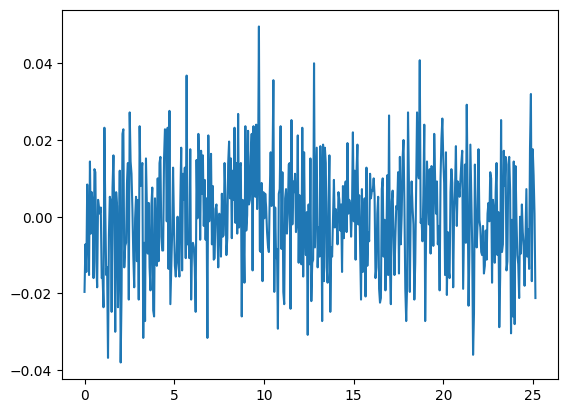

In [45]:
plt.plot(time_list, signal_X)

In [49]:
wax = np.fft.fftshift(np.fft.fftfreq(len(time_list), d=time_list[1]-time_list[0]))*2*np.pi
signal_ft = np.fft.fftshift(np.fft.fft(signal_X*np.exp(-time_list/50)))
# np.save("signal_500_8.npy", signal_ft)
# np.save("wax.npy", wax)

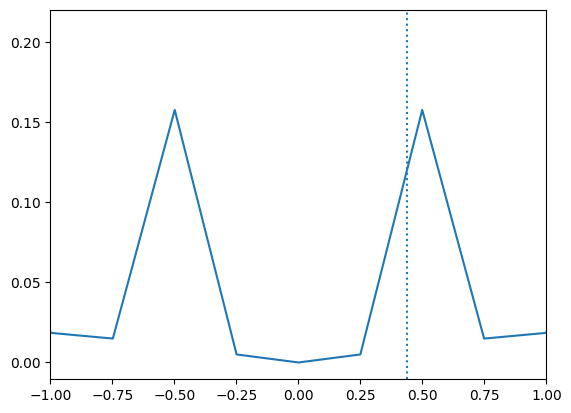

In [52]:

plt.plot(wax,np.imag(signal_ft)**2)

plt.xlim(-1,1)
plt.axvline(0.439, ls=":")
